In [1]:
%load_ext watermark
%watermark -p torch,lightning

torch    : 1.12.1
lightning: 2022.9.15



In [2]:
import lightning as L
import torch
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule

In [3]:
num_epochs = 200

### With Restarts

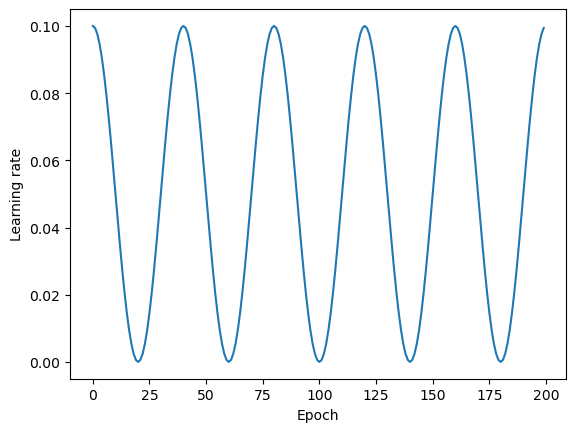

In [4]:
import matplotlib.pyplot as plt

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs/10)
lrs = []


for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.plot(lrs);

### Classic cosine annealing (decay per epoch)

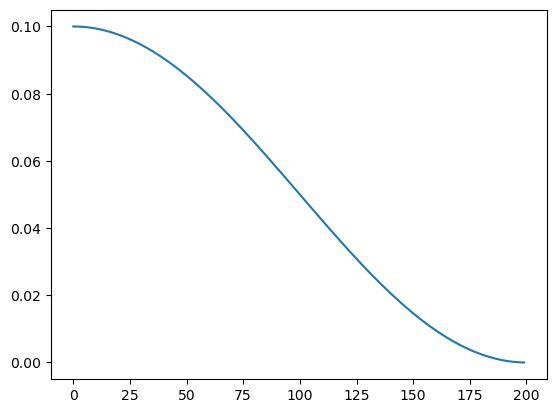

In [5]:
import matplotlib.pyplot as plt


model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
lrs = []



for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)

### Classic cosine annealing (decay per batch)

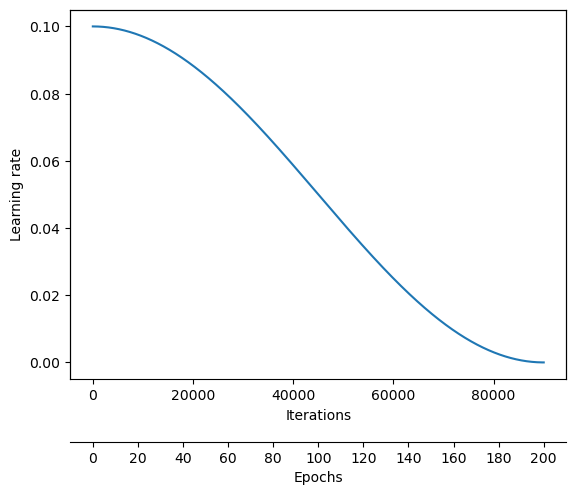

In [6]:
import matplotlib.pyplot as plt

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


dm = CustomDataModule()
dm.setup("training")
num_steps = num_epochs * len(dm.train_dataloader())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
lrs = []


for i in range(num_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()


ax1 = plt.subplot(1, 1, 1)
ax1.set_ylabel("Learning rate")
ax1.set_xlabel("Iterations")
ax1.plot(lrs)

###################
# Set second x-axis
ax2 = ax1.twiny()
newlabel = list(range(num_epochs+1))

newpos = [e * (num_steps // num_epochs) for e in newlabel]

ax2.set_xticks(newpos[::20])
ax2.set_xticklabels(newlabel[::20])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim());

plt.show()

### Classic cosine annealing (decay per batch) with warmup

In [7]:
# Code from https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annealing_warmup/scheduler.py

from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """
    
    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps
        
        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

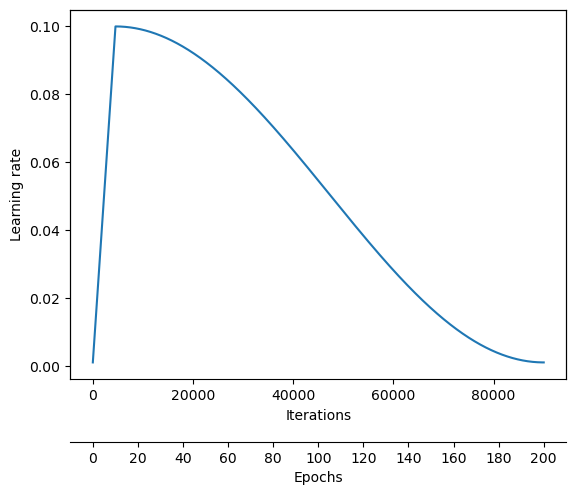

In [8]:
import math

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


dm = CustomDataModule()
dm.setup("training")
num_steps = num_epochs * len(dm.train_dataloader())
scheduler = CosineAnnealingWarmupRestarts(optimizer, warmup_steps=num_steps * 0.05, first_cycle_steps=num_steps)
lrs = []


for i in range(num_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()


ax1 = plt.subplot(1, 1, 1)
ax1.set_ylabel("Learning rate")
ax1.set_xlabel("Iterations")
ax1.plot(lrs)

###################
# Set second x-axis
ax2 = ax1.twiny()
newlabel = list(range(num_epochs+1))

newpos = [e * (num_steps // num_epochs) for e in newlabel]

ax2.set_xticks(newpos[::20])
ax2.set_xticklabels(newlabel[::20])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim());

plt.savefig('6-cosine-batch-decay-warmstart_lr.pdf')
plt.show()

In [9]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.BatchNorm1d(50),
            torch.nn.ReLU(),
            
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [10]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, cosine_t_max):
        super().__init__()

        self.learning_rate = learning_rate
        self.cosine_t_max = cosine_t_max
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        opt = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        sch = CosineAnnealingWarmupRestarts(opt, warmup_steps=num_steps * 0.05, first_cycle_steps=num_steps)


        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train_loss",
                "interval": "step", # step means "batch" here, default: epoch
                "frequency": 1, # default
            },
        }

In [11]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [12]:
%%capture --no-display

L.seed_everything(123)
dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1, cosine_t_max=num_steps)

trainer = L.Trainer(
    max_epochs=num_epochs,
    auto_lr_find=True,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
    callbacks=callbacks
)

results = trainer.tune(model=lightning_model, datamodule=dm)

Global seed set to 123
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.15848931924611143
Restoring states from the checkpoint path at /Users/sebastianraschka/Desktop/cosine/.lr_find_45c895f1-9e0b-4909-86f2-aeb8e091a6ab.ckpt


/var/folders/cb/1y0v6fzx5c54sztp5nqq39jc0000gn/T/ipykernel_17228/735961897.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


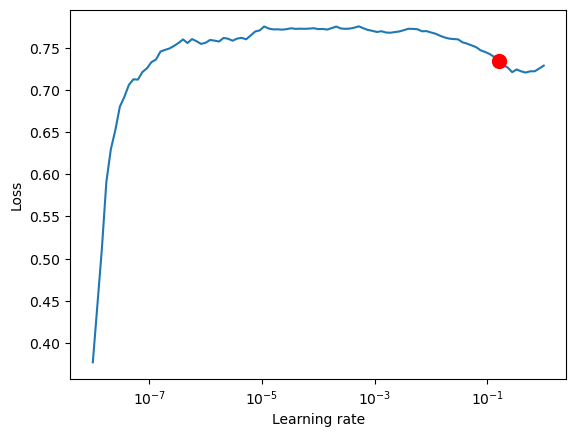

In [13]:
fig = results["lr_find"].plot(suggest=True)
# fig.savefig("lr_suggest.pdf")
fig.show()

In [14]:
# get suggestion
new_lr = results["lr_find"].suggestion()
print(new_lr)

# update hparams of the model
lightning_model.hparams.learning_rate = new_lr

0.15848931924611143


In [15]:
trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type       | Params
-----------------------------------------
0 | model     | PyTorchMLP | 15.6 K
1 | train_acc | Accuracy   | 0     
2 | val_acc   | Accuracy   | 0     
3 | test_acc  | Accuracy   | 0     
-----------------------------------------
15.6 K    Trainable params
0         Non-trainable params
15.6 K    Total params
0.062     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


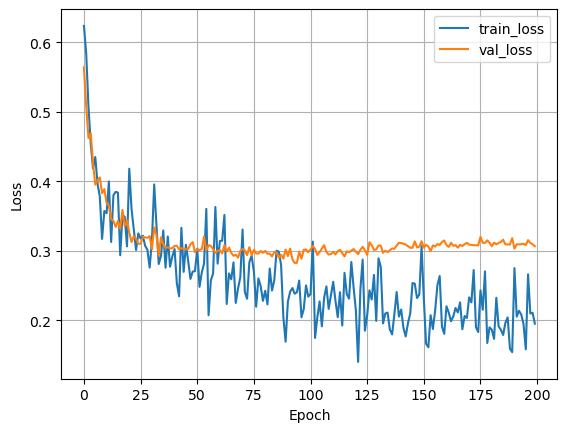

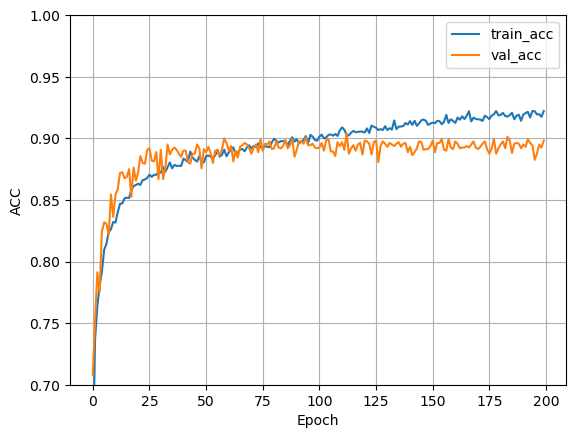

In [16]:
### Plot
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)


df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.ylim([0.7, 1.0])

plt.savefig('6-cosine-batch-decay-warmstart_acc.pdf')
plt.show()

In [17]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at logs/my-model/version_19/checkpoints/epoch=112-step=50850.ckpt
Loaded model weights from checkpoint at logs/my-model/version_19/checkpoints/epoch=112-step=50850.ckpt
/Users/sebastianraschka/miniforge3/envs/dl-fundamentals/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:231: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.890999972820282     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.890999972820282}]

In [18]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="last")

Restoring states from the checkpoint path at logs/my-model/version_19/checkpoints/last.ckpt
Loaded model weights from checkpoint at logs/my-model/version_19/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.890749990940094     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.890749990940094}]